# Analyze Dataset
---
1. Encode email data using BERT.
2. Split data into test and train splits.
3. Train an SVM model to predict the class of an email.
4. Test the model on unseen emails.

## Imports

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import torch
import joblib
import platform
from xgboost import XGBClassifier

## Load Data

In [2]:
email_dataframe = pd.read_feather("../data/2_balanced_email_dataset.feather")

# Encode "Email Type" into a numerical format: 0 for ham, 1 for phishing, and 2 for spam
email_dataframe["label_id"] = email_dataframe["Email Type"].astype("category").cat.codes

## Encode Email Text using SBERT

Activate CUDA if available.

In [3]:
if platform.system() == "Windows":
    device = "cuda" if torch.cuda.is_available() else "cpu"
elif platform.system() == "Darwin":
    device = "mps" if torch.backends.mps.is_available() else "cpu"
else:
    device = "cpu"

# Store the variable to be used in 5. Demo Classify Emails.ipynb
%store device

print("Using device:", device)

Stored 'device' (str)
Using device: cpu


In [4]:
# Labels
X = email_dataframe["Email Text"]
y = email_dataframe["Email Type"]

# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [8]:
# tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)

# # Fit the vectorizer only on the training data and transform both sets
# X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
# X_test_tfidf = tfidf_vectorizer.transform(X_test)

# print(f"Original training samples: {X_train.shape[0]}")
# print(f"Vectorized training samples (Features): {X_train_tfidf.shape}")

In [5]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Fit the vectorizer only on the training data and transform both sets
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"Original training samples: {X_train.shape[0]}")
print(f"Vectorized training samples (Features): {X_train_tfidf.shape}")

Original training samples: 72000
Vectorized training samples (Features): (72000, 241061)


In [6]:
model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(le.classes_), # Should be 3: Ham, Spam, Phishing
    eval_metric='merror',      # Multi-class error rate
    use_label_encoder=False,   # Recommended setting for newer versions
    random_state=42
)
model.fit(X_train_tfidf, y_train_encoded)

# Predict
y_pred_encoded = model.predict(X_test_tfidf)
y_pred = le.inverse_transform(y_pred_encoded)

/home/prokope/Projects/PsyberWatch/.svm-venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [19:44:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [7]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ham       0.97      0.94      0.96      6000
       phish       0.94      0.92      0.93      6000
        spam       0.88      0.94      0.91      6000

    accuracy                           0.93     18000
   macro avg       0.93      0.93      0.93     18000
weighted avg       0.93      0.93      0.93     18000



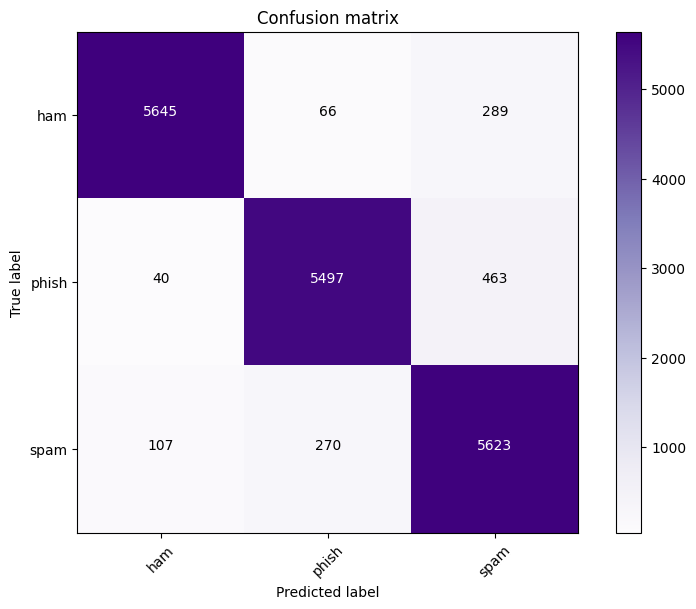

In [8]:
cm = confusion_matrix(y_test, y_pred, labels=le.classes_)
class_names = le.classes_


plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Purples)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

fmt = 'd'
threshold = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


Save as `.joblib` file for later reuse.

In [10]:
Path("../models").mkdir(parents=True, exist_ok=True)
joblib.dump(model, "../models/svm_model_2.joblib")

['../models/svm_model_2.joblib']